In [ ]:
import os
os.chdir("../")

In [2]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import SaltRemover
from networkx import to_numpy_matrix
from mmpa.mmp import MMP

from tqdm import tqdm
tqdm.pandas()

### import all activity values from glen's hdac paper

https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/document_chembl_id%3ACHEMBL1144843

In [3]:
df = pd.read_csv('/home/daniel/Downloads/DOWNLOAD-yHB7WOyNM1ncO7P50KZYChBxehUvIU9pGeCACYqyD4Y=.zip', sep=';', compression='zip')

### most common molecules

In [4]:
df['Compound Key'].value_counts()[0:10]

13b    23
15b    11
13d    11
13a    11
14b    11
3       9
15a     7
14c     7
15c     6
14a     6
Name: Compound Key, dtype: int64

### most common targets

In [5]:
df[['Target Name', 'Standard Type', 'Assay ChEMBL ID']].value_counts()[0:10]

Target Name            Standard Type  Assay ChEMBL ID
HERG                   IC50           CHEMBL927950       13
No relevant target     Solubility     CHEMBL927951       13
Histone deacetylase 1  IC50           CHEMBL927948       13
HCT-116                IC50           CHEMBL927949       13
No relevant target     LogD           CHEMBL927952       11
Rattus norvegicus      CL             CHEMBL927953        4
                       Vdss           CHEMBL927955        4
                       AUC            CHEMBL927956        4
                       T1/2           CHEMBL927954        3
                       AUC            CHEMBL927960        2
dtype: int64

### strip salts

In [6]:
def strip_salts(smiles):
    
    # parse smiles as rdkit molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # remove salts
    remover = SaltRemover.SaltRemover()
    mol, salts = remover.StripMolWithDeleted(mol)
    smiles = Chem.MolToSmiles(mol)
    
    # return
    return smiles

In [7]:
df['Stripped'] = df.Smiles.apply(strip_salts)
df.Stripped.unique().size

13

### remove test 'set' from mmp

In [8]:
training = ~df['Compound Key'].isin(['13c', '14d'])

### create cartesian product of molecules test in the same assay

In [9]:
df_pairs = pd.merge(df[training], df[training], on='Assay ChEMBL ID')
df_pairs = df_pairs[['Stripped_x', 'Stripped_y']].drop_duplicates()
df_pairs

,Stripped_x,Stripped_y
0,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...
1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
2,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
3,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
4,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...
...,...,...
116,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
117,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCN(C(C)C)CC2)cnc1-c1ccc(C(=O)Nc2cccc...
118,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
119,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1


### identify pairs

In [10]:
def apply_mmpa(prospective_pair):

    # prepare potential atom-atom mappings and create correspondence graph
    mmp = MMP(prospective_pair.Stripped_x, prospective_pair.Stripped_y, fuzziness=5)
    mmp.createCorrespondence()
    mmp.findCliques()
    mmp.eliminateMCS(radius=3)
    
    # append frags to output
    prospective_pair['Fragment_x'] = mmp.getFragment1()
    prospective_pair['Fragment_y'] = mmp.getFragment2()
    prospective_pair['SMIRKS'] = mmp.getSmirks()
    prospective_pair['PercentMCS'] = mmp.getPercentMCS()
    
    # return
    return prospective_pair

In [11]:
df_pairs = df_pairs.progress_apply(apply_mmpa, axis=1)
df_pairs = df_pairs[~pd.isna(df_pairs.SMIRKS)]
df_pairs.sample(3).transpose()

100%|██████████| 121/121 [03:02<00:00,  1.50s/it]


,32,106,109
Stripped_x,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Stripped_y,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCN(C(C)C)CC2)cnc1-c1ccc(C(=O)Nc2cccc...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
Fragment_x,ccc(F)c(-c)n,CN1CCC1,c-c(n)c(C)ccCN1CCC1
Fragment_y,ccc(Cl)c(-c)n,CC(C)N1CCN(C)CC1,c-c(n)c(Cl)ccCN1CCN(C(C)C)CC1
SMIRKS,[#6:13]:[#6:33](:[#6:29](:[#6:7](:[#7:32])-[#6...,[#6:6](-[#7:11]1-[#6:17](-[#6](-[#6:16]-1(-[H]...,[#6:27](-[#6:24](:[#6:26](:[#6:8]-[#6:10](-[#7...
PercentMCS,96.9697,88.5246,85.2459


### quality control, demonstrate x -> y using reaction

In [12]:
def apply_reactions(reaction):
    
    # create reaction
    rxn = Chem.rdChemReactions.ReactionFromSmarts(reaction.SMIRKS)

    # enumerate products
    productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(reaction.Stripped_x)),))

    # given produces exist
    productlist = []
    for product in productset:
        productlist.append('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
    return list(set(productlist))

In [13]:
df_pairs['ProductList'] = df_pairs.progress_apply(apply_reactions, axis=1)
df_pairs.sample(3).transpose()

100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


,34,49,89
Stripped_x,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
Stripped_y,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C)...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
Fragment_x,CN1CCC1,ccc(C#N)c(-c)n,c-c(n)c(F)ccCN1CCC1
Fragment_y,CC(C)N1CCN(C)CC1,ccc(C)c(-c)n,c-c(n)c(C#N)ccCN1CCN(C(C)C)CC1
SMIRKS,[#6:18](-[#7:19]1-[#6:21](-[#6](-[#6:22]-1(-[H...,[#6:16]:[#6:30](:[#6:31](:[#6:4](:[#7:28])-[#6...,[#6:1]-[#6:4](:[#7:23]):[#6:27](:[#6:25](:[#6:...
PercentMCS,88.8889,95.3846,83.871
ProductList,[CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)...,[CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C...,[CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)...


### check no failures and identify multiple products

In [14]:
df_pairs.apply(lambda x: x.Stripped_y not in x.ProductList, axis=1).sum()

0

In [15]:
df_pairs.ProductList.apply(lambda x: len(x) > 1).sum()

0

### populate 'pCHEMBL Value' column with logD values and filter exact measurements

In [16]:
df_exact = df[['Stripped', 'Assay ChEMBL ID', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value']].copy()
df_exact['pChEMBL Value'] = df_exact.apply(lambda x: x['Standard Value'] if x['Standard Type'] == 'LogD' else x['pChEMBL Value'], axis=1)
df_exact = df_exact[(df_exact['Standard Relation']=="'='") & (pd.notna(df_exact['pChEMBL Value']))]
df_exact.sample(3).transpose()

,88,35,102
Stripped,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Assay ChEMBL ID,CHEMBL927952,CHEMBL927952,CHEMBL927952
Standard Type,LogD,LogD,LogD
Standard Relation,'=','=','='
Standard Value,1.6,1.28,1.22
Standard Units,NaN,NaN,NaN
pChEMBL Value,1.6,1.28,1.22


### combine twice with confirmed molecular pairs

In [17]:
df_merge = df_pairs.merge(df_exact, left_on='Stripped_x', right_on='Stripped')
df_merge = df_merge.merge(df_exact, left_on=['Stripped_y', 'Assay ChEMBL ID'], right_on=['Stripped', 'Assay ChEMBL ID'])
df_merge['pChEMBL Value_delta'] = df_merge['pChEMBL Value_y'] - df_merge['pChEMBL Value_x'] 
df_merge.sample(3).transpose()

,111,28,39
Stripped_x,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Stripped_y,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...
Fragment_x,c-c(n)c(Cl)ccCN1CCN(C(C)C)CC1,ccc(C)c(-c)n,CN1CCC1
Fragment_y,c-c(n)c(F)ccCN1CCC1,ccc(C#N)c(-c)n,CCN1CCN(C)CC1
SMIRKS,[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#7]1-[#6](...,[#6:27](-[#6:24](:[#6:28](:[#6:14])-[H]):[#6:4...,[#6:13](-[#7:15]1-[#6:16](-[#6](-[#6:17]-1(-[H...
PercentMCS,85.2459,94.7368,90.3226
ProductList,[Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1],[N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1],[CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C...
Stripped_x,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Assay ChEMBL ID,CHEMBL927948,CHEMBL927949,CHEMBL927952
Standard Type_x,IC50,IC50,LogD


### filter mcs > 90% and aggregate by fragments

In [18]:
df_agg = df_merge[df_merge.PercentMCS > 90]
df_agg = pd.pivot_table(df_agg, values='pChEMBL Value_delta', index=['Fragment_x', 'Fragment_y'], columns='Assay ChEMBL ID', aggfunc=['count','mean'])
df_agg.columns = [' '.join(col).strip() for col in df_agg.columns.values]
df_agg

count CHEMBL927948  count CHEMBL927949  \
Fragment_x     Fragment_y                                               
CCN(CC)C(C)C   CCN(CC)CC                      3.0                 3.0   
CCN(CC)CC      CCN(CC)C(C)C                   3.0                 3.0   
CCN1CCN(C)CC1  CN1CCC1                        1.0                 1.0   
CN1CCC1        CCN1CCN(C)CC1                  1.0                 1.0   
ccc(C#N)c(-c)n ccc(C)c(-c)n                   3.0                 3.0   
               ccc(Cl)c(-c)n                  2.0                 2.0   
               ccc(F)c(-c)n                   2.0                 2.0   
ccc(C)c(-c)n   ccc(C#N)c(-c)n                 3.0                 3.0   
               ccc(Cl)c(-c)n                  2.0                 2.0   
               ccc(F)c(-c)n                   2.0                 2.0   
ccc(Cl)c(-c)n  ccc(C#N)c(-c)n                 2.0                 2.0   
               ccc(C)c(-c)n                   2.0                 2.0   
               ccc(F)c(-c)n                   1.0                 1.0   
ccc(F)c(-c)n   ccc(C#N)c(-c)n                 2.0                 2.0   
               ccc(C)c(-c)n                   2.0                 2.0   
               ccc(Cl)c(-c)n                  1.0                 1.0   

                               count CHEMBL927950  count CHEMBL927952  \
Fragment_x     Fragment_y                                               
CCN(CC)C(C)C   CCN(CC)CC                      1.0                 3.0   
CCN(CC)CC      CCN(CC)C(C)C                   1.0                 3.0   
CCN1CCN(C)CC1  CN1CCC1                        NaN                 1.0   
CN1CCC1        CCN1CCN(C)CC1                  NaN                 1.0   
ccc(C#N)c(-c)n ccc(C)c(-c)n                   NaN                 3.0   
               ccc(Cl)c(-c)n                  1.0                 2.0   
               ccc(F)c(-c)n                   NaN                 2.0   
ccc(C)c(-c)n   ccc(C#N)c(-c)n                 NaN                 3.0   
               ccc(Cl)c(-c)n                  NaN                 2.0   
               ccc(F)c(-c)n                   NaN                 2.0   
ccc(Cl)c(-c)n  ccc(C#N)c(-c)n                 1.0                 2.0   
               ccc(C)c(-c)n                   NaN                 2.0   
               ccc(F)c(-c)n                   NaN                 1.0   
ccc(F)c(-c)n   ccc(C#N)c(-c)n                 NaN                 2.0   
               ccc(C)c(-c)n                   NaN                 2.0   
               ccc(Cl)c(-c)n                  NaN                 1.0   

                               mean CHEMBL927948  mean CHEMBL927949  \
Fragment_x     Fragment_y                                             
CCN(CC)C(C)C   CCN(CC)CC               -0.016667          -0.003333   
CCN(CC)CC      CCN(CC)C(C)C             0.016667           0.003333   
CCN1CCN(C)CC1  CN1CCC1                  0.000000           0.000000   
CN1CCC1        CCN1CCN(C)CC1            0.000000           0.000000   
ccc(C#N)c(-c)n ccc(C)c(-c)n            -0.293333          -0.266667   
               ccc(Cl)c(-c)n           -0.160000          -0.365000   
               ccc(F)c(-c)n            -0.605000          -0.545000   
ccc(C)c(-c)n   ccc(C#N)c(-c)n           0.293333           0.266667   
               ccc(Cl)c(-c)n            0.110000          -0.140000   
               ccc(F)c(-c)n            -0.305000          -0.255000   
ccc(Cl)c(-c)n  ccc(C#N)c(-c)n           0.160000           0.365000   
               ccc(C)c(-c)n            -0.110000           0.140000   
               ccc(F)c(-c)n            -0.400000          -0.320000   
ccc(F)c(-c)n   ccc(C#N)c(-c)n           0.605000           0.545000   
               ccc(C)c(-c)n             0.305000           0.255000   
               ccc(Cl)c(-c)n            0.400000           0.320000   

                               mean CHEMBL927950  mean CHEMBL927952  
Fragment_x     Fragment_y                           

### finally plot (figure 3 from wizepairz paper)

In [23]:
%matplotlib inline

<AxesSubplot:xlabel='mean CHEMBL927952', ylabel='mean CHEMBL927948'>

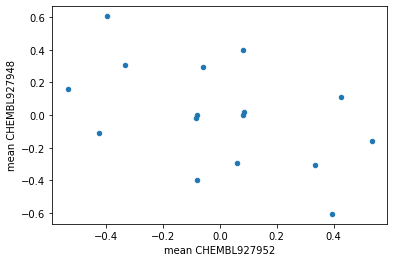

In [24]:
df_agg.plot.scatter('mean CHEMBL927952', 'mean CHEMBL927948')